<h1> HMS - Harmful Brain Activity Classification </h1>

> Motivation : 
> * To understand this competition and make our first submission.
> * explore & visualize data and create some new features.
> * Train simple CatBoost/XGBoost model

# | Introduction

In this competition we are given **EEG signals** and using these signal data we have to classify samples in **6 different classes.**


**Target Labels (6 different classes):**<br>
**1. Seizure:** `Seizue` is a sudden uncontrolled electrical disturbance in brain. On an EEG, seizures are characterized by abnormal electrical discharges. There may be `spikes`, `sharp waves`, or other distinctive patterns indicative of `increased neuronal activity`.<br>
**2. GPD (generalized periodic discharge):** rhythmic, repeteative discharge cover widespread area of the brain. <br>
**3. LPD (Lateralized peridic discharge):** this is also rhythmic & repeteative discharge but occurs predominantly on one side of the brain.<br>
**4. LRDA (Lateralized rhythmic Delta activity):** LRDA is characterized by rhythmic, slow-wave activity predominantly on one side of the brain.<br>
**5. GRDA (Generalized Rhythmic Delta Activity):** GRDA involves rhythmic delta activity that is distributed widely across both hemispheres of the brain.<br>
**6. Other:** If we are not sure for any of the above classes, it will be classified as other<br>


## Train.csv File

`train.csv`, in this file we are given: 
* ids for `Patients`, `eeg signal`, `spectrogram signals`. 
* `votes` for all the six classes and `expert_consensus` which gives the majority voting or averaging.
* `eeg & spectrogram offset seconds`, The time between the beginning of the consolidated EEG/spect. and this subsample. will discuss this in detail.

For each unique `eeg_id` we are given a single parquet file in `train_eegs` folder. let's see this by an example:<br><br>
**Example:**  for eeg_id = `1628180742`


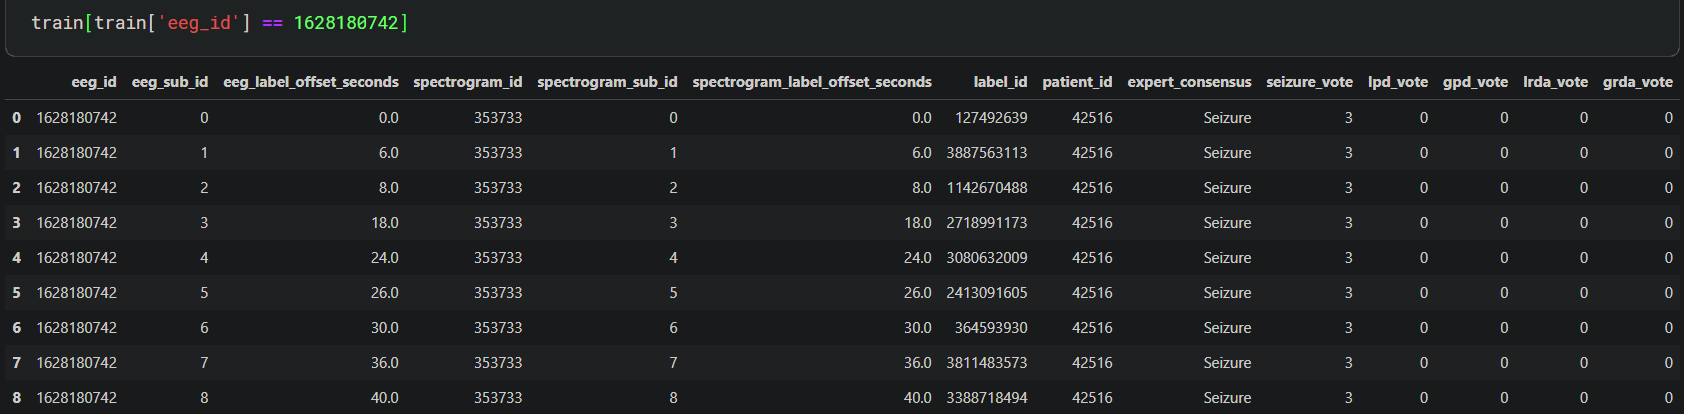

We have 9 rows in train file for eeg id = `1628180742`. Each row represent to **50 Sec** data in the parquet file. `eeg_label_offset_seconds` gives the starting point of the 50 Sec data. like in row 3rd `eeg_label_offset_seconds` is **8.0**. This means for 3rd row we will take data from parquet file starting from 8.0 second and upto 58 seconds (each eeg data is 50 seconds). <br>

Each sample in eeg parquet file represent to 1/200 sec, so to load 50 seconds data we will take 10000(50*200) samples from parquet file. code example: 

> 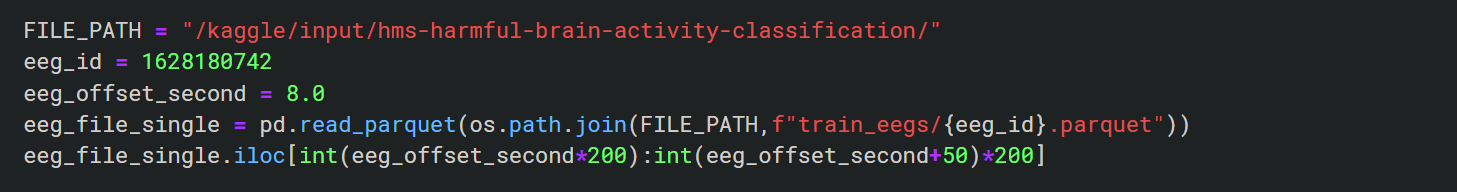

For each **50 sec** EEG data, we have to predict label using **10 sec** data from the **center.** in data description page this line is given as: The expert annotators reviewed 50 second long EEG samples plus matched spectrograms covering 10 a minute window centered at the same time and labeled the central 10 seconds. 

## Test.csv File

in test file, we are given 3 things<br>
&emsp;1. eeg_id: Each eeg_id parquet file is 50 Sec long. <br>
&emsp;2. spectrogram_id<br>
&emsp;3. patient_id<br>

## For Submission 

* eeg_id  
* [seizure / lpd / gpd / lrda / grda / other]_vote - The target columns. our predictions must be probabilities. 

# | Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import warnings
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


import catboost as cat
from catboost import Pool
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# | Parameters

In [ ]:
SEED = 43
FILE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification/"
TARGET_COLUMNS =  ['seizure_vote', 'lpd_vote',
                 'gpd_vote', 'lrda_vote',
                 'grda_vote', 'other_vote']
TARGET = "expert_consensus"
READ_EEG_PARQUET = False 

# | Import Data

In [ ]:
!ls "/kaggle/input/hms-harmful-brain-activity-classification/"

In [ ]:
train = pd.read_csv(os.path.join(FILE_PATH,"train.csv"))
test = pd.read_csv(os.path.join(FILE_PATH,"test.csv"))
sample_sub = pd.read_csv(os.path.join(FILE_PATH,"sample_submission.csv"))

# | Explore Train / Test

In [ ]:
# train data
train.head()

In [ ]:
# test data
test

In [ ]:
# train/test shapes and unique ids
# for eeg, patient & spectrogram
# only one sample in test data is given to us

print("\nTrain File:")
print(f"Total number of samples: {train.shape[0]}")
print(f"Total nuber of unique `EEG ids`: {train.eeg_id.nunique()}")
print(f"Total number of Patients: {train.patient_id.nunique()}")
print(f"Total nuber of unique `Spectrogram ids`: {train.spectrogram_id.nunique()}")

print("\nTest File")
print(f"Total number of samples: {test.shape[0]}")

In [ ]:
# null values
# Dtypes & unique value count

from prettytable import PrettyTable
x = PrettyTable()
x.add_column('features',train.columns.tolist())
x.add_column('Null values' , train.isnull().sum().values)
x.add_column("Unique value count", train.nunique().values)
x.add_column('Dtype',train.dtypes.values)
print(x)

# | Load Single EEG Parquet File

In [ ]:
# we will select a eeg_id & read parquet file.

eeg_id = train.eeg_id.unique()[0]
eeg_file_single = pd.read_parquet(os.path.join(FILE_PATH,f"train_eegs/{eeg_id}.parquet"))

In [ ]:
# This is our single Parquet file
# we have a total of 17089 (unique eeg ids) files in train_eegs folder

print(f"Total number of samples: {len(eeg_file_single)}")
print(f"Total number of features: {eeg_file_single.shape[1]}")
eeg_file_single.head()

in the above file we have **18000** rows, which means we have **90 (18000/200)** seconds data in this paraquet file.<br>
out of these 90 seconds we sill select 50 seconds EEG data. `eeg_label_offset_seconds` is the starting point for the **50** seconds data.

In [ ]:
# we are taking eeg offset second for second row (index = 1)

eeg_label_offset_second = train[train.eeg_id == eeg_id].loc[1,'eeg_label_offset_seconds']
print(f"eeg offset second value: {eeg_label_offset_second}")

# taking 50 second data from the complete file. starting time is 6 seconds for this exmaple
eeg_offset_file = eeg_file_single.iloc[int(eeg_label_offset_second*200):int(eeg_label_offset_second+50)*200]
print(f"Total number of samples in offset file: {len(eeg_offset_file)}")
eeg_offset_file.head()

# | Data Visualization (EEG File - 50 sec)

In [ ]:
#let's plot first 10 columns
plot_all = True

if plot_all:
    cols_ = eeg_offset_file.columns.tolist()
    fig, axs = plt.subplots(10,2,figsize = (15,20))
    axs = axs.flat
    for i, c in enumerate(cols_):
        sns.lineplot(data = eeg_offset_file,x = eeg_offset_file.index, 
                     y = c, ax = axs[i])
    plt.tight_layout()
    plt.show()
else:
    cols_ = eeg_offset_file.columns.tolist()[:10]
    fig, axs = plt.subplots(5,2,figsize = (15,10))
    axs = axs.flat
    for i, c in enumerate(cols_):
        sns.lineplot(data = eeg_offset_file,x = eeg_offset_file.index, 
                     y = c, ax = axs[i])
    plt.tight_layout()
    plt.show()


<p><i class="fa fa-hand-o-right" style="font-size:24px;color:#0000FF"></i>&emsp;We can see some graphs shows correlation, so let's check correlation next</p>

### Feature Correlation HeatMap

In [ ]:
# correlation matrix for single eeg offset file
plt.figure(figsize=(10,6))
df_corr = eeg_offset_file.corr(method='pearson')
sns.heatmap(df_corr[:10],annot=True , cmap="BuPu")
plt.tight_layout()
plt.show()

### Highly correlated feature pairs :


In [ ]:
# strong correlated features pairs
thershold = 0.6

highly_correlated_pairs = (df_corr.abs() > thershold) & (df_corr.abs() < 1)
correlated_feature_pairs = set() 
for i in range(len(eeg_offset_file.columns)):
    for j in range(i + 1, len(eeg_offset_file.columns)):
        if highly_correlated_pairs.iloc[i, j]:
            correlated_feature_pairs.add((eeg_offset_file.columns[i], eeg_offset_file.columns[j]))


x = PrettyTable()
for feature_pair in correlated_feature_pairs:
    x.add_row(feature_pair)
x.field_names = ['Feature 1', 'Feature 2']
print(x)

In [ ]:
del eeg_file_single, eeg_offset_file

# | Load All EEG Files

In [ ]:
# reading all parquet file takes around 15 minutes. to seva time we 
# loaded all files and calculated features mean, max & min, saved these
# features in a csv file. we can directly load this file.
# change READ_EEG_PARQUET = True to read all data

eeg_columns = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz',
                   'Cz', 'Pz','Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    
if READ_EEG_PARQUET:
    path = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"
    files = os.listdir(path)
    eeg = {}
    for i, f in enumerate(files):
        eeg_single_f = pd.read_parquet(f"{path}{f}") 
        file_name = int(f.split(".")[0])
        eeg[file_name] = eeg_single_f.values
    
    for c in eeg_columns:
        train[c+"_mean"] = None
        train[c+"_max"] = None
        train[c+"_min"] = None
    for i, eeg_id in enumerate(train['eeg_id']):
        eeg_offset_second = train.loc[i,"eeg_label_offset_seconds"]
        for j,col in enumerate(eeg_columns):
            temp = eeg[eeg_id][int(eeg_offset_second*200):int(eeg_offset_second+50)*200,j]
            train.at[i,col+"_mean"] = np.nanmean(temp)
            train.at[i,col+"_max"] = np.nanmax(temp)
            train.at[i,col+"_min"] = np.nanmin(temp)

else:
    train_eeg = pd.read_csv("/kaggle/input/preprocessed-data/train_eegs.csv")

In [ ]:
train_eeg.head()

In [ ]:
# Load Test EEG Files

path = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"
files = os.listdir(path)
eeg = {}
for i, f in enumerate(files):
    eeg_single_f = pd.read_parquet(f"{path}{f}") 
    file_name = int(f.split(".")[0])
    eeg[file_name] = eeg_single_f.values

for c in eeg_columns:
    test[c+"_mean"] = None
    test[c+"_max"] = None
    test[c+"_min"] = None
for i, eeg_id in enumerate(test['eeg_id']):
    for j,col in enumerate(eeg_columns):
        temp = eeg[eeg_id]
        test.at[i,col+"_mean"] = np.nanmean(temp)
        test.at[i,col+"_max"] = np.nanmax(temp)
        test.at[i,col+"_min"] = np.nanmin(temp)


In [ ]:
test

In [ ]:
# plot target variable

target_counts = train[TARGET].value_counts()
labels= ['seizure','lpd','gpd','lrda','grda','other']

fig, axs = plt.subplots(1,2,figsize=(10,4))

axs[0].pie(
    train[TARGET].value_counts(),
    labels=labels,
    shadow=True, 
    explode=[.1 for i in range(train[TARGET].nunique())],  # Adjust the explode based on the number of unique values
    autopct='%1.f%%',
)
plt.suptitle('Target label in Train Dataset', fontsize=13, fontweight='bold')

sns.countplot(train,x = TARGET,ax=axs[1])
plt.tight_layout()
plt.show()

# | Model Training

In [ ]:
FEATURES = [ 'Fp1_mean','Fp1_max', 'Fp1_min', 'F3_mean', 'F3_max', 'F3_min', 'C3_mean',
             'C3_max', 'C3_min', 'P3_mean', 'P3_max', 'P3_min', 'F7_mean', 'F7_max',
             'F7_min', 'T3_mean', 'T3_max', 'T3_min', 'T5_mean', 'T5_max', 'T5_min',
             'O1_mean', 'O1_max', 'O1_min', 'Fz_mean', 'Fz_max', 'Fz_min', 'Cz_mean',
             'Cz_max', 'Cz_min', 'Pz_mean', 'Pz_max', 'Pz_min', 'Fp2_mean',
             'Fp2_max', 'Fp2_min', 'F4_mean', 'F4_max', 'F4_min', 'C4_mean',
             'C4_max', 'C4_min', 'P4_mean', 'P4_max', 'P4_min', 'F8_mean', 'F8_max',
             'F8_min', 'T4_mean', 'T4_max', 'T4_min', 'T6_mean', 'T6_max', 'T6_min',
             'O2_mean', 'O2_max', 'O2_min', 'EKG_mean', 'EKG_max', 'EKG_min']

X = train_eeg[FEATURES]
y = train_eeg[TARGET]
X_test = test[FEATURES]

In [ ]:
# Normalize data
scaler = StandardScaler()
X[FEATURES] = scaler.fit_transform(X[FEATURES])
X_test[FEATURES] = scaler.transform(X_test[FEATURES])

In [ ]:
# train model

skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=SEED)
for fold, (train_idx,val_idx) in enumerate(skf.split(X,y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    train_pool = Pool(X_train,y_train)
    val_pool = Pool(X_val,y_val)

    model = cat.CatBoostClassifier(
        task_type = "GPU",
        loss_function = "MultiClass"
    )
    
    model.fit(train_pool, verbose=300, eval_set=val_pool)
#

In [ ]:
# train on complete data

model = cat.CatBoostClassifier(
        task_type = "GPU",
        loss_function = "MultiClass"
    )
    
model.fit(X,y, verbose = 300)
pred = model.predict_proba(test[FEATURES])

# | Final Submission


In [ ]:
sub = sample_sub.copy()
sub[TARGET_COLUMNS] = pred
sub.to_csv("submission.csv",index=False)
sub

if you see any typos please let me know. Upvote if you like. Thanks, Happy Coding !!